In [1]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [3]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import json
from collections import defaultdict, Counter
import re
from datetime import datetime
import time

In [4]:
api_token = userdata.get('Api_Token')
os.environ["REPLICATE_API_TOKEN"] = api_token

model = "ibm-granite/granite-3.3-8b-instruct"
granite_llm = Replicate(
    model=model,
    replicate_api_token=api_token,
)

In [5]:
df = pd.read_csv('youtube_comments_hp.csv', delimiter=';')

print(f"Dataset Overview:")
print(f"Total records: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"HP Types: {df['jenis_hp'].unique()}")

Dataset Overview:
Total records: 3113
Columns: ['jenis_hp', 'username', 'comment', 'likes']
HP Types: ['Samsung A56' 'Xiaomi 14T' 'Vivo V40 5G']


In [6]:
# Data cleaning
df = df.dropna(subset=['comment', 'jenis_hp'])
df['comment'] = df['comment'].astype(str)
df['comment_length'] = df['comment'].str.len()
df['likes'] = pd.to_numeric(df['likes'], errors='coerce').fillna(0)

In [7]:
# Filter comments (remove too short/long comments)
df = df[(df['comment_length'] >= 10) & (df['comment_length'] <= 500)]

print(f"After cleaning: {len(df)} records")

After cleaning: 3014 records


In [8]:
class GraniteSentimentAnalyzer:
    def __init__(self, model):
        self.model = model
        self.analysis_cache = {}

    def analyze_batch(self, comments, hp_type, batch_size=3):
        """
        Analyze sentiment with enhanced prompt engineering
        """
        results = []

        # Optimized parameters for sentiment analysis
        parameters = {
            "top_k": 10,
            "top_p": 0.9,
            "max_tokens": 200,
            "min_tokens": 50,
            "repetition_penalty": 1.3,
            "temperature": 0.7
        }

        for i in range(0, len(comments), batch_size):
            batch = comments[i:i+batch_size]

            # Enhanced prompt with specific instructions
            comments_text = "\n".join([f"Comment {j+1}: {comment}"
                                     for j, comment in enumerate(batch)])

            prompt = f"""
You are an expert smartphone analyst. Analyze these {hp_type} smartphone comments from YouTube.

For each comment, provide EXACTLY this format:
Comment X: Sentiment: [Positive/Negative/Neutral], Aspects: [specific features mentioned], Confidence: [High/Medium/Low]

Guidelines:
- Positive: Praise, satisfaction, recommendation
- Negative: Complaints, problems, dissatisfaction
- Neutral: Questions, neutral observations, mixed opinions
- Aspects: battery, camera, performance, design, price, display, build_quality, software, etc.
- Be concise and accurate

{comments_text}

Analysis:
"""

            try:
                response = self.model.invoke(prompt, **parameters)
                batch_results = self._parse_response(response, len(batch))
                results.extend(batch_results)

                # Progress tracking
                if (i // batch_size + 1) % 10 == 0:
                    print(f"Processed {i + len(batch)} comments for {hp_type}...")

            except Exception as e:
                print(f"Error in batch {i//batch_size + 1}: {str(e)}")
                # Fallback results
                for _ in batch:
                    results.append({
                        'sentiment': 'Neutral',
                        'aspects': 'general',
                        'confidence': 'Low',
                        'error': True
                    })

            # Rate limiting
            time.sleep(1)

        return results

    def _parse_response(self, response, expected_count):
        """Parse Granite model response into structured data"""
        results = []
        lines = response.strip().split('\n')

        for line in lines:
            if 'Comment' in line and 'Sentiment:' in line:
                try:
                    # Extract sentiment
                    sentiment_match = re.search(r'Sentiment:\s*\[?([^\],]+)\]?', line)
                    sentiment = sentiment_match.group(1).strip() if sentiment_match else 'Neutral'

                    # Extract aspects
                    aspects_match = re.search(r'Aspects:\s*\[?([^\],]+)\]?', line)
                    aspects = aspects_match.group(1).strip() if aspects_match else 'general'

                    # Extract confidence
                    confidence_match = re.search(r'Confidence:\s*\[?([^\],]+)\]?', line)
                    confidence = confidence_match.group(1).strip() if confidence_match else 'Medium'

                    results.append({
                        'sentiment': sentiment,
                        'aspects': aspects.lower(),
                        'confidence': confidence,
                        'error': False
                    })
                except Exception:
                    results.append({
                        'sentiment': 'Neutral',
                        'aspects': 'general',
                        'confidence': 'Low',
                        'error': True
                    })

        # Ensure we have results for all comments
        while len(results) < expected_count:
            results.append({
                'sentiment': 'Neutral',
                'aspects': 'general',
                'confidence': 'Low',
                'error': True
            })

        return results[:expected_count]

# Initialize analyzer
analyzer = GraniteSentimentAnalyzer(granite_llm)

In [9]:
def analyze_smartphone_sentiment(df, analyzer, sample_size=100):
    """
    Complete sentiment analysis pipeline for all HP types
    """
    results = {}

    for hp_type in df['jenis_hp'].unique():
        print(f"Analyzing {hp_type}...")

        # Sample data for analysis
        hp_data = df[df['jenis_hp'] == hp_type].copy()

        # Stratified sampling based on likes (popular comments get priority)
        if len(hp_data) > sample_size:
            # Sort by likes and take top comments + random sample
            top_comments = hp_data.nlargest(sample_size//2, 'likes')
            remaining = hp_data.drop(top_comments.index)
            random_sample = remaining.sample(n=sample_size//2, random_state=42)
            hp_sample = pd.concat([top_comments, random_sample])
        else:
            hp_sample = hp_data

        # Perform sentiment analysis
        comments = hp_sample['comment'].tolist()
        sentiment_results = analyzer.analyze_batch(comments, hp_type)

        # Add results to dataframe
        hp_sample = hp_sample.reset_index(drop=True)
        for i, result in enumerate(sentiment_results):
            for key, value in result.items():
                hp_sample.loc[i, f'ai_{key}'] = value

        results[hp_type] = hp_sample
        print(f"Completed analysis for {hp_type}: {len(hp_sample)} comments")

    return results

analysis_results = analyze_smartphone_sentiment(df, analyzer, sample_size=150)


Analyzing Samsung A56...
Processed 30 comments for Samsung A56...
Processed 60 comments for Samsung A56...
Processed 90 comments for Samsung A56...
Processed 120 comments for Samsung A56...
Processed 150 comments for Samsung A56...
Completed analysis for Samsung A56: 150 comments
Analyzing Xiaomi 14T...
Processed 30 comments for Xiaomi 14T...
Processed 60 comments for Xiaomi 14T...
Processed 90 comments for Xiaomi 14T...
Processed 120 comments for Xiaomi 14T...
Processed 150 comments for Xiaomi 14T...
Completed analysis for Xiaomi 14T: 150 comments
Analyzing Vivo V40 5G...
Processed 30 comments for Vivo V40 5G...
Processed 60 comments for Vivo V40 5G...
Processed 90 comments for Vivo V40 5G...
Processed 120 comments for Vivo V40 5G...
Processed 150 comments for Vivo V40 5G...
Completed analysis for Vivo V40 5G: 150 comments


In [10]:
class SmartphoneInsightsExtractor:
    def __init__(self, analysis_results):
        self.results = analysis_results
        self.insights = {}

    def extract_comprehensive_insights(self):
        """Extract detailed insights for each smartphone"""

        for hp_type, data in self.results.items():
            insights = self._analyze_single_phone(data, hp_type)
            self.insights[hp_type] = insights

        return self.insights

    def _analyze_single_phone(self, data, hp_type):
        """Detailed analysis for a single smartphone"""

        # Basic sentiment distribution
        sentiment_dist = data['ai_sentiment'].value_counts()
        total_comments = len(data)

        # Aspect analysis
        aspects_analysis = self._analyze_aspects(data)

        # Confidence analysis
        confidence_dist = data['ai_confidence'].value_counts()

        # Engagement analysis (likes correlation)
        avg_likes_by_sentiment = data.groupby('ai_sentiment')['likes'].mean()

        # Extract representative comments
        sample_comments = self._extract_sample_comments(data)

        # Calculate sentiment scores
        sentiment_score = self._calculate_sentiment_score(sentiment_dist, total_comments)

        return {
            'total_comments_analyzed': total_comments,
            'sentiment_distribution': sentiment_dist.to_dict(),
            'sentiment_percentages': (sentiment_dist / total_comments * 100).to_dict(),
            'sentiment_score': sentiment_score,
            'aspects_analysis': aspects_analysis,
            'confidence_distribution': confidence_dist.to_dict(),
            'engagement_by_sentiment': avg_likes_by_sentiment.to_dict(),
            'sample_comments': sample_comments,
            'strong_points': aspects_analysis['positive_aspects'],
            'weak_points': aspects_analysis['negative_aspects']
        }

    def _analyze_aspects(self, data):
        """Analyze mentioned aspects by sentiment"""
        positive_aspects = []
        negative_aspects = []
        neutral_aspects = []

        for _, row in data.iterrows():
            aspects = str(row['ai_aspects']).split(',')
            sentiment = row['ai_sentiment']

            for aspect in aspects:
                aspect = aspect.strip().lower()
                if aspect and aspect != 'general' and aspect != 'nan':
                    if 'positive' in sentiment.lower():
                        positive_aspects.append(aspect)
                    elif 'negative' in sentiment.lower():
                        negative_aspects.append(aspect)
                    else:
                        neutral_aspects.append(aspect)

        return {
            'positive_aspects': Counter(positive_aspects).most_common(5),
            'negative_aspects': Counter(negative_aspects).most_common(5),
            'neutral_aspects': Counter(neutral_aspects).most_common(5)
        }

    def _extract_sample_comments(self, data):
        """Extract representative comments for each sentiment"""
        samples = {}

        for sentiment in ['Positive', 'Negative', 'Neutral']:
            sentiment_data = data[data['ai_sentiment'].str.contains(sentiment, case=False, na=False)]
            if not sentiment_data.empty:
                # Sort by likes and confidence
                top_comments = sentiment_data.nlargest(3, 'likes')['comment'].tolist()
                samples[sentiment.lower()] = top_comments
            else:
                samples[sentiment.lower()] = []

        return samples

    def _calculate_sentiment_score(self, sentiment_dist, total):
        """Calculate overall sentiment score (-100 to +100)"""
        positive = sentiment_dist.get('Positive', 0)
        negative = sentiment_dist.get('Negative', 0)

        if total == 0:
            return 0

        return ((positive - negative) / total) * 100

# Extract insights
extractor = SmartphoneInsightsExtractor(analysis_results)
comprehensive_insights = extractor.extract_comprehensive_insights()

In [11]:
import plotly.graph_objects as go

hp_types = list(comprehensive_insights.keys())
sentiments = ['Positive', 'Neutral', 'Negative']
colors = {'Positive': '#2ca02c', 'Neutral': '#ff7f0e', 'Negative': '#d62728'}

fig = go.Figure()
for s in sentiments:
    values = [comprehensive_insights[hp]['sentiment_percentages'].get(s, 0) for hp in hp_types]
    fig.add_trace(go.Bar(x=hp_types, y=values, name=s, marker_color=colors[s]))

fig.update_layout(
    title="Sentiment Distribution by Smartphone",
    barmode='group',
    yaxis_title="Percentage (%)",
    xaxis_title="Smartphone"
)
fig.show()


In [12]:
hp_types = list(comprehensive_insights.keys())
scores = [comprehensive_insights[hp].get('sentiment_score', 0) for hp in hp_types]
colors = ['#2ca02c' if sc > 0 else '#d62728' if sc < 0 else '#ff7f0e' for sc in scores]

fig = go.Figure(go.Bar(x=hp_types, y=scores, marker_color=colors))
fig.update_layout(
    title="Sentiment Scores by Smartphone",
    yaxis_title="Score",
    xaxis_title="Smartphone",
)
fig.show()


In [13]:
import plotly.graph_objects as go

# Ambil semua HP
hp_types = list(comprehensive_insights.keys())

# Ambil semua kategori confidence (Low, Medium, High) dari data pertama
all_conf_labels = set()
for hp in hp_types:
    all_conf_labels.update(comprehensive_insights[hp]['confidence_distribution'].keys())
all_conf_labels = list(all_conf_labels)

# Pakai versi label pendek (Low/Medium/High)
def shorten_label(label):
    if "Low" in label:
        return "Low"
    elif "Medium" in label:
        return "Medium"
    elif "High" in label:
        return "High"
    return "Other"

short_labels = [shorten_label(lbl) for lbl in all_conf_labels]

# Buat trace per kategori
fig = go.Figure()
for label in set(short_labels):
    values = []
    for hp in hp_types:
        conf_dist = comprehensive_insights[hp]['confidence_distribution']
        # jumlahkan semua yang masuk kategori label pendek itu
        total = sum(v for k,v in conf_dist.items() if shorten_label(k) == label)
        values.append(total)
    fig.add_trace(go.Bar(name=label, x=hp_types, y=values))

fig.update_layout(
    barmode='group',
    title="Confidence Distribution (Bar Chart)",
    xaxis_title="Smartphone",
    yaxis_title="Count"
)
fig.show()


In [14]:
sentiments = ['Positive', 'Neutral', 'Negative']
fig = go.Figure()

for hp in comprehensive_insights.keys():
    eng = comprehensive_insights[hp].get('engagement_by_sentiment', {})
    x = [s for s in sentiments if s in eng]
    y = [eng[s] for s in x]
    fig.add_trace(go.Scatter(x=x, y=y, mode='markers+lines', name=hp))

fig.update_layout(
    title="Engagement by Sentiment",
    yaxis_title="Likes",
    xaxis_title="Sentiment"
)
fig.show()


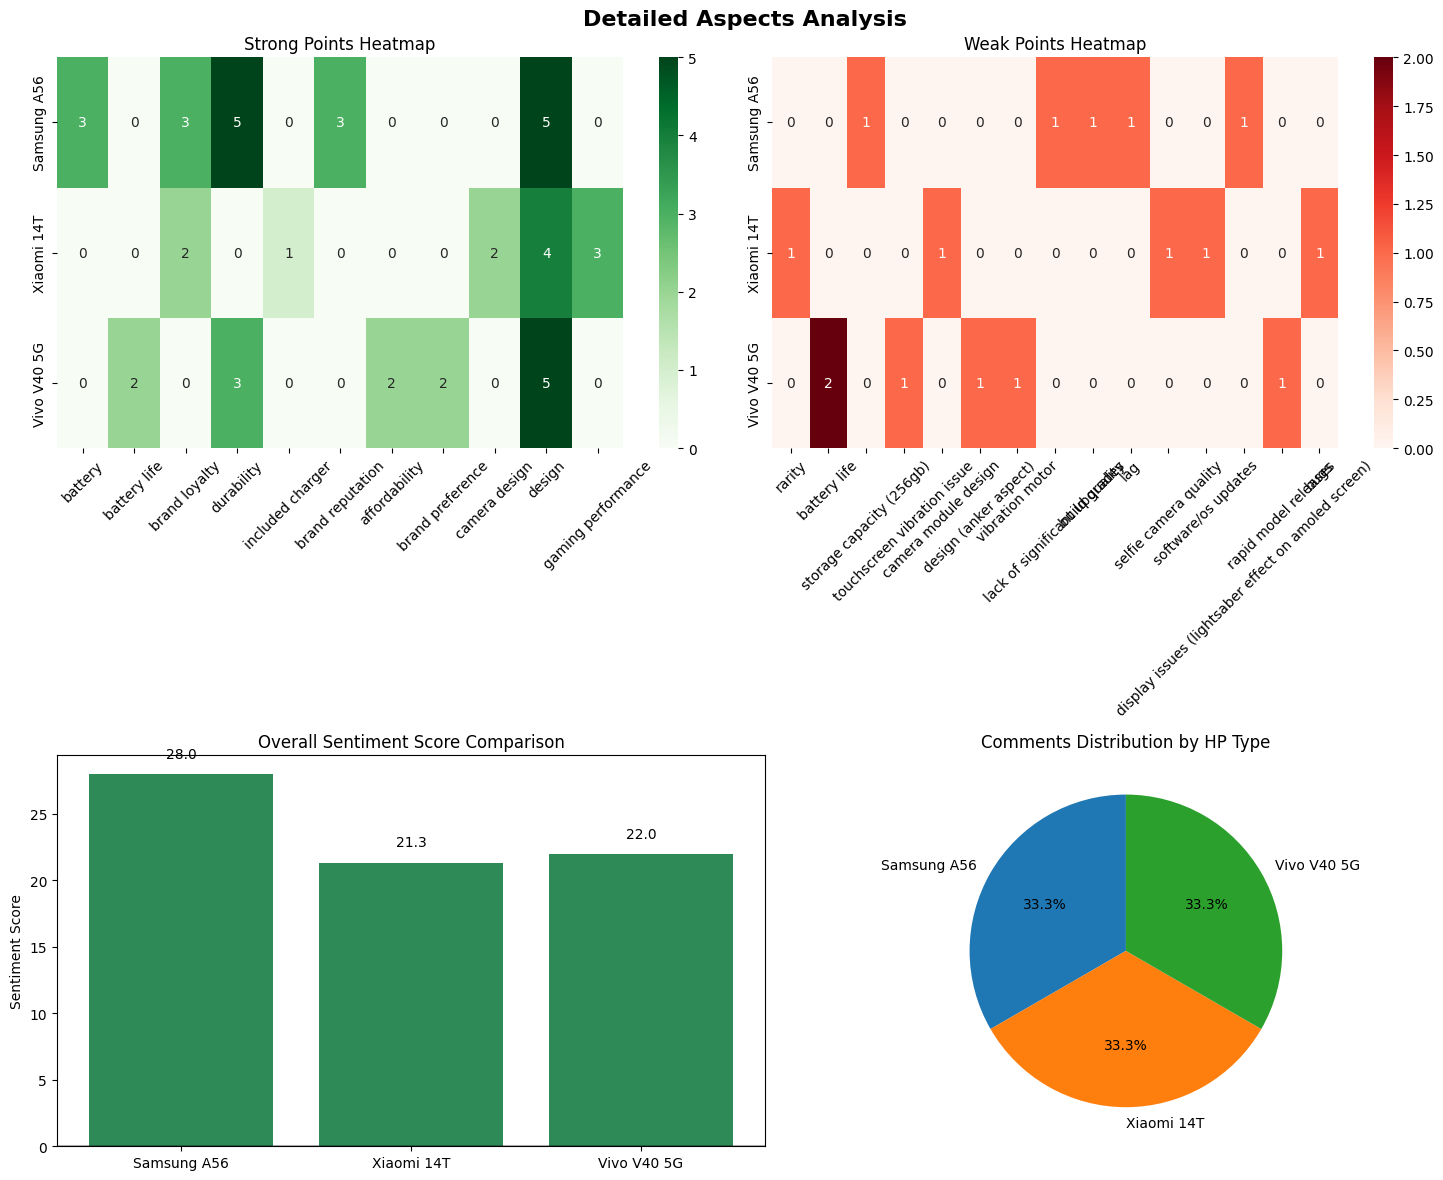

In [32]:
def create_comprehensive_visualizations(insights):
    """Create advanced visualizations for the analysis"""

    hp_types = list(insights.keys())


    # 2. Detailed Aspects Analysis
    create_aspects_visualization(insights)

def create_aspects_visualization(insights):
    """Create detailed aspects visualization"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Detailed Aspects Analysis', fontsize=16, fontweight='bold')

    hp_types = list(insights.keys())

    # Strong points comparison
    ax1 = axes[0, 0]
    strong_points_data = {}
    for hp in hp_types:
        strong_points = dict(insights[hp]['strong_points'])
        strong_points_data[hp] = strong_points

    # Create heatmap for strong points
    all_aspects = set()
    for hp_data in strong_points_data.values():
        all_aspects.update(hp_data.keys())

    matrix_strong = []
    aspect_labels = list(all_aspects)
    for hp in hp_types:
        row = [strong_points_data[hp].get(aspect, 0) for aspect in aspect_labels]
        matrix_strong.append(row)

    if matrix_strong and aspect_labels:
        sns.heatmap(matrix_strong, xticklabels=aspect_labels, yticklabels=hp_types,
                   annot=True, cmap='Greens', ax=ax1)
        ax1.set_title('Strong Points Heatmap')
        ax1.tick_params(axis='x', rotation=45)

    # Weak points comparison
    ax2 = axes[0, 1]
    weak_points_data = {}
    for hp in hp_types:
        weak_points = dict(insights[hp]['weak_points'])
        weak_points_data[hp] = weak_points

    all_weak_aspects = set()
    for hp_data in weak_points_data.values():
        all_weak_aspects.update(hp_data.keys())

    matrix_weak = []
    weak_aspect_labels = list(all_weak_aspects)
    for hp in hp_types:
        row = [weak_points_data[hp].get(aspect, 0) for aspect in weak_aspect_labels]
        matrix_weak.append(row)

    if matrix_weak and weak_aspect_labels:
        sns.heatmap(matrix_weak, xticklabels=weak_aspect_labels, yticklabels=hp_types,
                   annot=True, cmap='Reds', ax=ax2)
        ax2.set_title('Weak Points Heatmap')
        ax2.tick_params(axis='x', rotation=45)

    # Sentiment score comparison
    ax3 = axes[1, 0]
    scores = [insights[hp]['sentiment_score'] for hp in hp_types]
    colors = ['#2E8B57' if score > 10 else '#DC143C' if score < -10 else '#FF8C00' for score in scores]
    bars = ax3.bar(hp_types, scores, color=colors)
    ax3.set_title('Overall Sentiment Score Comparison')
    ax3.set_ylabel('Sentiment Score')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + (1 if height >= 0 else -3),
                f'{score:.1f}', ha='center', va='bottom' if height >= 0 else 'top')

    # Comments distribution
    ax4 = axes[1, 1]
    total_comments = [insights[hp]['total_comments_analyzed'] for hp in hp_types]
    ax4.pie(total_comments, labels=hp_types, autopct='%1.1f%%', startangle=90)
    ax4.set_title('Comments Distribution by HP Type')

    plt.tight_layout()
    plt.show()

# Generate visualizations
create_comprehensive_visualizations(comprehensive_insights)

In [28]:
class BusinessRecommendationEngine:
    def __init__(self, insights):
        self.insights = insights

    def generate_comprehensive_report(self):
        """Generate business-focused recommendations"""

        report = {
            'executive_summary': self._create_executive_summary(),
            'competitive_analysis': self._create_competitive_analysis(),
            'recommendations': self._create_recommendations(),
            'market_positioning': self._analyze_market_positioning()
        }

        return report

    def _create_executive_summary(self):
        """Create executive summary with key findings"""
        summary = {}

        # Rank smartphones by sentiment score
        rankings = [(hp, data['sentiment_score']) for hp, data in self.insights.items()]
        rankings.sort(key=lambda x: x[1], reverse=True)

        summary['performance_ranking'] = rankings
        summary['market_leader'] = rankings[0][0] if rankings else None
        summary['improvement_needed'] = rankings[-1][0] if rankings else None

        # Overall market sentiment
        total_positive = sum(data['sentiment_distribution'].get('Positive', 0) for data in self.insights.values())
        total_negative = sum(data['sentiment_distribution'].get('Negative', 0) for data in self.insights.values())
        total_comments = sum(data['total_comments_analyzed'] for data in self.insights.values())

        summary['market_sentiment'] = {
            'positive_rate': (total_positive / total_comments * 100) if total_comments > 0 else 0,
            'negative_rate': (total_negative / total_comments * 100) if total_comments > 0 else 0,
            'total_analyzed': total_comments
        }

        return summary

    def _create_competitive_analysis(self):
        """Analyze competitive positioning"""
        analysis = {}

        for hp_type, data in self.insights.items():
            strengths = [aspect for aspect, count in data['strong_points']]
            weaknesses = [aspect for aspect, count in data['weak_points']]

            analysis[hp_type] = {
                'competitive_advantages': strengths[:3],
                'competitive_disadvantages': weaknesses[:3],
                'sentiment_score': data['sentiment_score'],
                'user_satisfaction': data['sentiment_percentages'].get('Positive', 0)
            }

        return analysis

    def _create_recommendations(self):
        """Generate actionable business recommendations"""
        recommendations = {}

        for hp_type, data in self.insights.items():
            hp_recommendations = []

            # Based on weak points
            weak_points = data['weak_points']
            if weak_points:
                top_weakness = weak_points[0][0]
                hp_recommendations.append({
                    'priority': 'High',
                    'category': 'Product Improvement',
                    'action': f"Improve {top_weakness} - most criticized aspect",
                    'rationale': f"Mentioned negatively {weak_points[0][1]} times"
                })

            # Based on strong points
            strong_points = data['strong_points']
            if strong_points:
                top_strength = strong_points[0][0]
                hp_recommendations.append({
                    'priority': 'Medium',
                    'category': 'Marketing Focus',
                    'action': f"Emphasize {top_strength} in marketing campaigns",
                    'rationale': f"Praised positively {strong_points[0][1]} times"
                })

            # Based on sentiment score
            if data['sentiment_score'] < 0:
                hp_recommendations.append({
                    'priority': 'High',
                    'category': 'Brand Management',
                    'action': "Launch customer satisfaction improvement program",
                    'rationale': f"Negative sentiment score: {data['sentiment_score']:.1f}"
                })

            recommendations[hp_type] = hp_recommendations

        return recommendations

    def _analyze_market_positioning(self):
        """Analyze market positioning for each phone"""
        positioning = {}

        for hp_type, data in self.insights.items():
            sentiment_score = data['sentiment_score']
            positive_rate = data['sentiment_percentages'].get('Positive', 0)

            if sentiment_score > 20 and positive_rate > 50:
                position = "Market Leader"
            elif sentiment_score > 0 and positive_rate > 40:
                position = "Strong Contender"
            elif sentiment_score > -10 and positive_rate > 30:
                position = "Average Performer"
            else:
                position = "Needs Improvement"

            positioning[hp_type] = {
                'market_position': position,
                'sentiment_score': sentiment_score,
                'positive_rate': positive_rate,
                'key_differentiator': data['strong_points'][0][0] if data['strong_points'] else 'None identified'
            }

        return positioning

# Generate business recommendations
recommender = BusinessRecommendationEngine(comprehensive_insights)
business_report = recommender.generate_comprehensive_report()


In [26]:
# Display executive summary
print("EXECUTIVE SUMMARY:")
print(f"Total comments analyzed: {business_report['executive_summary']['market_sentiment']['total_analyzed']}")
print(f"Market positive sentiment: {business_report['executive_summary']['market_sentiment']['positive_rate']:.1f}%")
print(f"Market negative sentiment: {business_report['executive_summary']['market_sentiment']['negative_rate']:.1f}%")

EXECUTIVE SUMMARY:
Total comments analyzed: 450
Market positive sentiment: 37.8%
Market negative sentiment: 14.0%


In [27]:
print(f"PERFORMANCE RANKING:")
for i, (hp, score) in enumerate(business_report['executive_summary']['performance_ranking'], 1):
    print(f"{i}. {hp}: {score:.1f} sentiment score")


PERFORMANCE RANKING:
1. Samsung A56: 28.0 sentiment score
2. Vivo V40 5G: 22.0 sentiment score
3. Xiaomi 14T: 21.3 sentiment score


In [25]:
print(f"KEY FINDINGS:")
for hp_type, data in comprehensive_insights.items():
    print(f"\n{hp_type.upper()}:")
    print(f"  • Sentiment Score: {data['sentiment_score']:.1f}")
    print(f"  • Positive Rate: {data['sentiment_percentages'].get('Positive', 0):.1f}%")
    if data['strong_points']:
        print(f"  • Top Strength: {data['strong_points'][0][0]} ({data['strong_points'][0][1]} mentions)")
    if data['weak_points']:
        print(f"  • Main Weakness: {data['weak_points'][0][0]} ({data['weak_points'][0][1]} mentions)")

KEY FINDINGS:

SAMSUNG A56:
  • Sentiment Score: 28.0
  • Positive Rate: 44.0%
  • Top Strength: design (5 mentions)
  • Main Weakness: build quality (1 mentions)

XIAOMI 14T:
  • Sentiment Score: 21.3
  • Positive Rate: 32.0%
  • Top Strength: design (4 mentions)
  • Main Weakness: selfie camera quality (1 mentions)

VIVO V40 5G:
  • Sentiment Score: 22.0
  • Positive Rate: 37.3%
  • Top Strength: design (5 mentions)
  • Main Weakness: battery life (2 mentions)


In [ ]:
# Save comprehensive results
all_results_df = pd.concat(analysis_results.values(), keys=analysis_results.keys())
all_results_df.to_csv('comprehensive_smartphone_analysis.csv')

In [24]:
# Save insights as JSON
with open('smartphone_insights_report.json', 'w') as f:
    json.dump({
        'analysis_insights': comprehensive_insights,
        'business_report': business_report,
        'metadata': {
            'analysis_date': datetime.now().isoformat(),
            'model_used': 'IBM Granite 3.3-8B-Instruct',
            'total_comments_analyzed': sum(data['total_comments_analyzed'] for data in comprehensive_insights.values())
        }
    }, f, indent=2, default=str)

In [23]:
print(f"BUSINESS RECOMMENDATIONS:")
for hp_type, recommendations in business_report['recommendations'].items():
    print(f"\n{hp_type.upper()}:")
    for rec in recommendations:
        print(f"  • {rec['priority']} Priority: {rec['action']}")
        print(f"    Rationale: {rec['rationale']}")

BUSINESS RECOMMENDATIONS:

SAMSUNG A56:
  • High Priority: Improve build quality - most criticized aspect
    Rationale: Mentioned negatively 1 times
  • Medium Priority: Emphasize design in marketing campaigns
    Rationale: Praised positively 5 times

XIAOMI 14T:
  • High Priority: Improve selfie camera quality - most criticized aspect
    Rationale: Mentioned negatively 1 times
  • Medium Priority: Emphasize design in marketing campaigns
    Rationale: Praised positively 4 times

VIVO V40 5G:
  • High Priority: Improve battery life - most criticized aspect
    Rationale: Mentioned negatively 2 times
  • Medium Priority: Emphasize design in marketing campaigns
    Rationale: Praised positively 5 times
